# Exercício 2
## 3ª Lista de Fundamentos em Redes Neurais e Aprendizagem Estatística
### by Lorran de Araújo Durães Soares

# Imports:

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from tensorflow import keras

np.random.seed(42) # setando semente

# Pré processamento:

Baixando conjunto de imagens do cifar10:

In [15]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas as categorias aviões e carros:

In [16]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Plotando imagens exemplos da base de dados:

In [17]:
def plot_images_grid(images, titles, rows=2, cols=4):

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()  # achata o array de eixos para facilitar o acesso

    for img, title, ax in zip(images, titles, axes):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

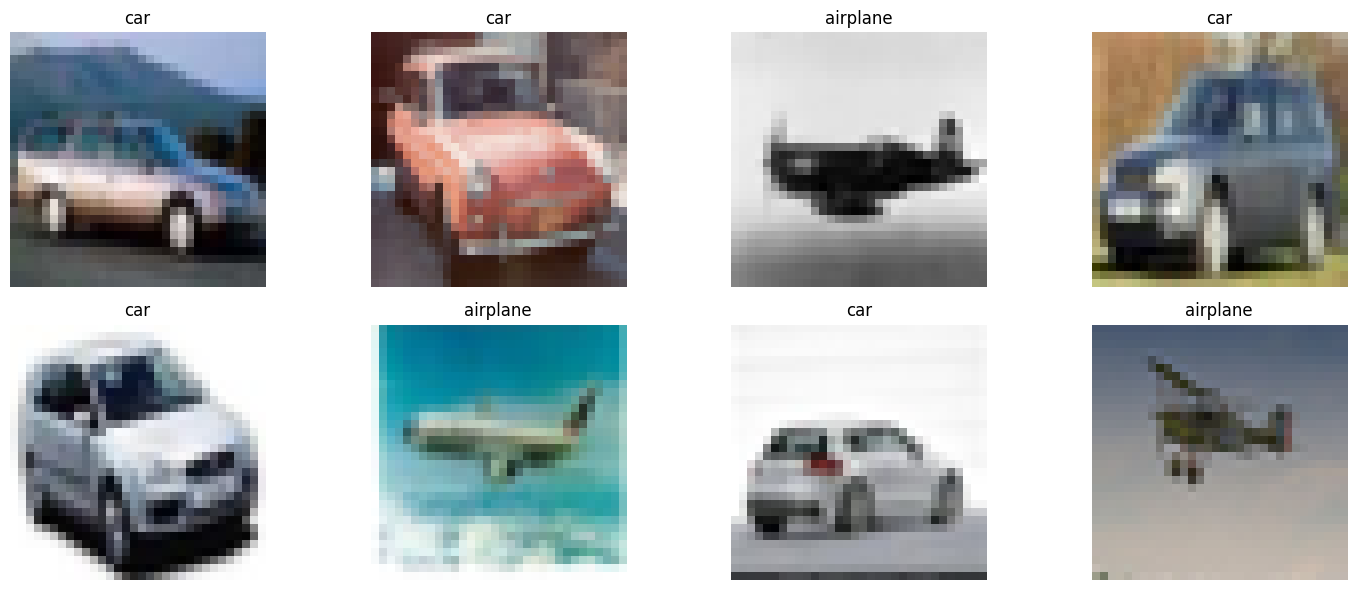

In [18]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 12
list_imgs = []
example_label = []

for i in range(8):
    list_imgs.append(x_filt[num_imagem*i])
    example_label.append(category_labels[y_filt[num_imagem*i][0]])

plot_images_grid(images=list_imgs, titles=example_label)

Dividindo dados em conjunto de treino e testes:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_filt, y_filt, test_size=0.3, random_state=42, shuffle=True, stratify=y_filt)

Plota histograma de frequência para verificação de desbalanceamento de dados:

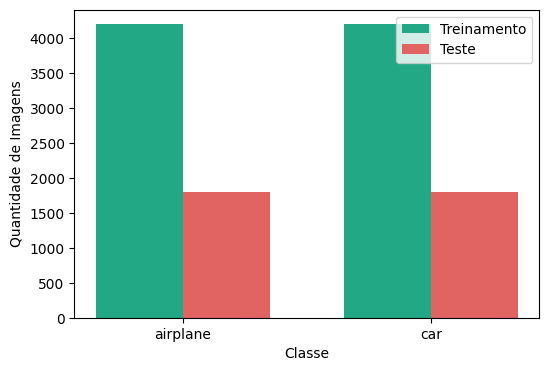

In [20]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_counts_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_counts_test = dict(zip(unique_test, counts_test))

class_names = ['airplane', 'car']

# Largura das barras
bar_width = 0.35

indices = np.arange(len(class_counts_train))

colors_train = plt.cm.viridis(0.6)  # Cor para o conjunto de treinamento
colors_test = plt.cm.plasma(0.6)  # Cor para o conjunto de teste

# Plotar o histograma do conjunto de treinamento
plt.figure(figsize=(6, 4))
plt.bar(indices, class_counts_train.values(), width=bar_width, label='Treinamento', color=colors_train)

# Plotar o histograma do conjunto de teste
plt.bar(indices + bar_width, class_counts_test.values(), width=bar_width, label='Teste', color=colors_test)

# Configurar o gráfico
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
plt.xticks(indices + bar_width / 2, class_names, rotation=0)
plt.legend()

plt.show()

### Encontrando melhores hiperparâmetros:

In [23]:
def criar_modelo(optimizer='adam', learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False, layers_cnn=2, neuro_cnn=32, layers_mlp=1, neuro_mlp=128):
    
    model = Sequential()
    model.add(layers.Conv2D(neuro_cnn, (3, 3), activation='relu', input_shape=(32, 32, 3)))

    for i in range(layers_cnn):
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(neuro_cnn*2, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    
    for j in range(layers_mlp):    
        model.add(layers.Dense(int(neuro_mlp/(j+1)), activation='relu'))
        
    model.add(layers.Dense(10, activation='softmax'))


    # Configurando modelo
    if optimizer == 'adam':
        optimizer = Adam(
            learning_rate=learning_rate,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon,
            amsgrad=amsgrad
        )
    else:
        raise ValueError("O otimizador fornecido não é suportado")

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=criar_modelo, verbose=0)

# grade de parametros para a busca
param_grid = {
    'batch_size': [32,64],
    'epochs': [10,15],
    'optimizer__learning_rate': [0.001],
    'optimizer__beta_1': [0.95],
    'optimizer__beta_2': [0.9999],
    'optimizer__epsilon': [1e-8],
    'optimizer__amsgrad': [True],
    'layers_cnn': [2,4,6],
    'neuro_cnn': [32,64,128],
    'layers_mlp': [1,2,4],
    'neuro_mlp': [64,128,256]
}

# realizacao da busca
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_filt, y_filt)

print(f"Melhor: {grid_result.best_score_} usando {grid_result.best_params_}")

2024-09-02 11:12:18.907666: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 11:12:18.907781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 11:12:18.907810: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-02 11:12:18.907782: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly 

: 

# Modelo

Criando modelo:

In [13]:
def create_model(layers_cnn, neuro_cnn, layers_mlp, neuro_mlp):

    model = Sequential()
    model.add(layers.Conv2D(neuro_cnn, (3, 3), activation='relu', input_shape=(32, 32, 3)))

    for i in range(layers_cnn):
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(neuro_cnn*2, (3, 3), activation='relu'))
    
    model.add(layers.Flatten())
    
    for j in range(layers_mlp):    
        model.add(layers.Dense(neuro_mlp, activation='relu'))
        
    model.add(layers.Dense(10, activation='softmax'))

    # Correção na forma de definir os parâmetros do otimizador
    optimizer = Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999, epsilon=1e-8, amsgrad=True)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

    return model

In [30]:
def create_model():

    model = Sequential()

    model.add(layers.Conv2D(6, (5, 5), activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(16, (5, 5), activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(120, (5, 5), activation='tanh'))
    
    model.add(layers.Flatten())
        
    model.add(layers.Dense(84, activation='tanh'))
        
    model.add(layers.Dense(10, activation='softmax'))

    # Correção na forma de definir os parâmetros do otimizador
    optimizer = Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.9999, epsilon=1e-8, amsgrad=True)

    model.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

    return model

Treinando com 5 k-folds

In [43]:
# define o número de folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# lista para armazenar os históricos e as pontuações de cada fold
histories = []

# lista para armazenar cada modelo
models = []

# executa a validação cruzada
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    x_train2, x_val = X_train[train_index], X_train[val_index]
    y_train2, y_val = y_train[train_index], y_train[val_index]
    
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",          
        min_delta=0.0001,             
        patience=5,                 
        verbose=1,                   
        mode="max",                               
        restore_best_weights=True,   
        start_from_epoch=0,  
    )
    
    # cria e treina o modelo
    model = create_model()
    history = model.fit(x_train2, y_train2, epochs=30, batch_size=64,
                         validation_data=(x_val, y_val), callbacks= [early_stopping], verbose=1)
    
    
    models.append(model)
    
    # armazenar o historico do fold
    histories.append(history.history)
    
    # avalia e exibe a pontuação
    score = model.evaluate(x_val, y_val, verbose=0)
    print(f'Fold {fold + 1} - Acurácia: {score[1]:.4f}')

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6443 - loss: 0.7126 - val_accuracy: 0.8375 - val_loss: 0.3785
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8498 - loss: 0.3473 - val_accuracy: 0.8435 - val_loss: 0.3545
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8501 - loss: 0.3350 - val_accuracy: 0.8631 - val_loss: 0.3258
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8739 - loss: 0.3043 - val_accuracy: 0.8577 - val_loss: 0.3332
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8544 - loss: 0.3400 - val_accuracy: 0.8649 - val_loss: 0.3317
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8805 - loss: 0.2823 - val_accuracy: 0.8768 - val_loss: 0.2980
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8956 - loss: 0.2564 - val_accuracy: 0.8798 - val_loss: 0.2871
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8983 - loss: 0.2491 - val_accu

Plotando graficos de acurácia e perda para cada fold:

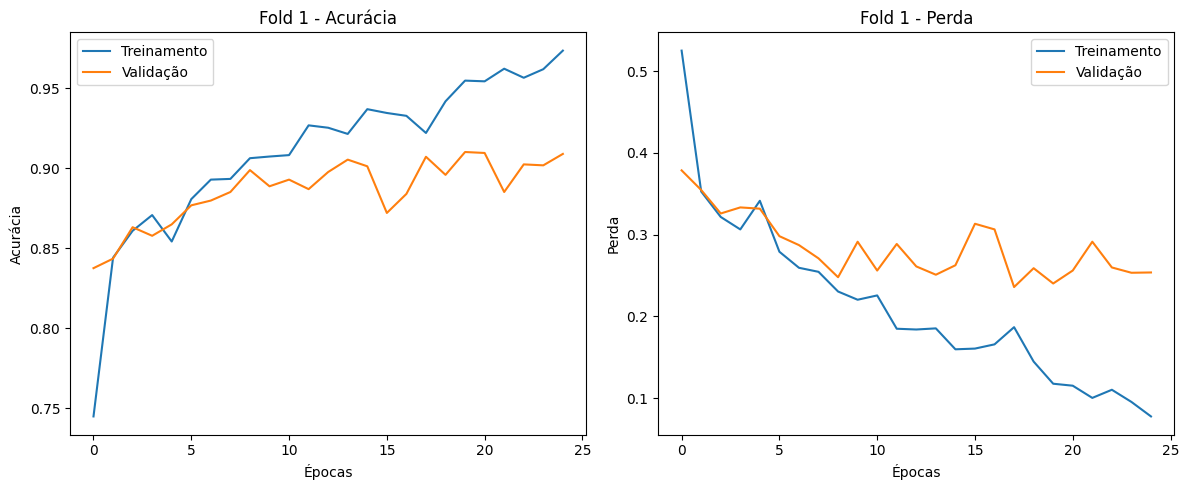

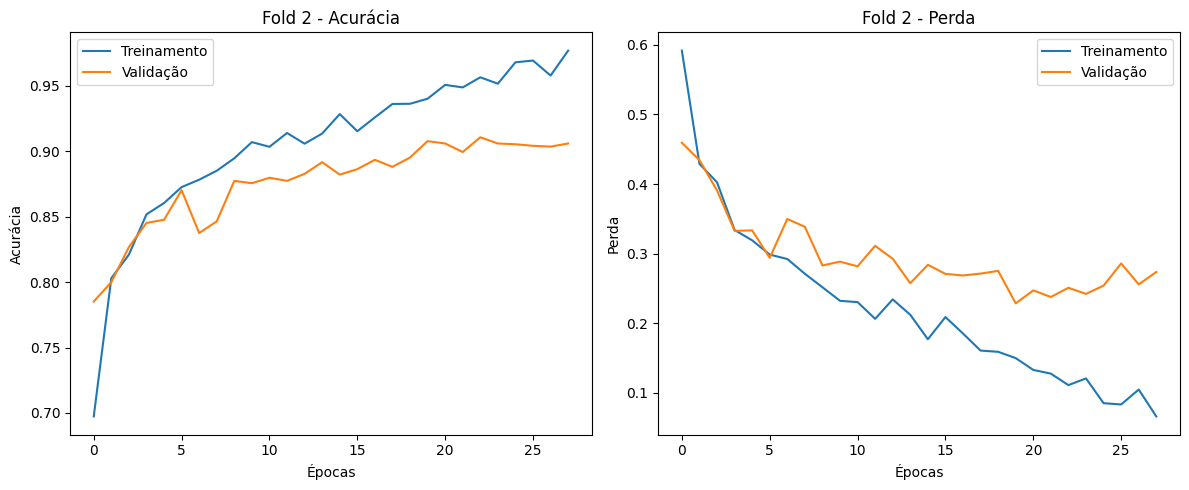

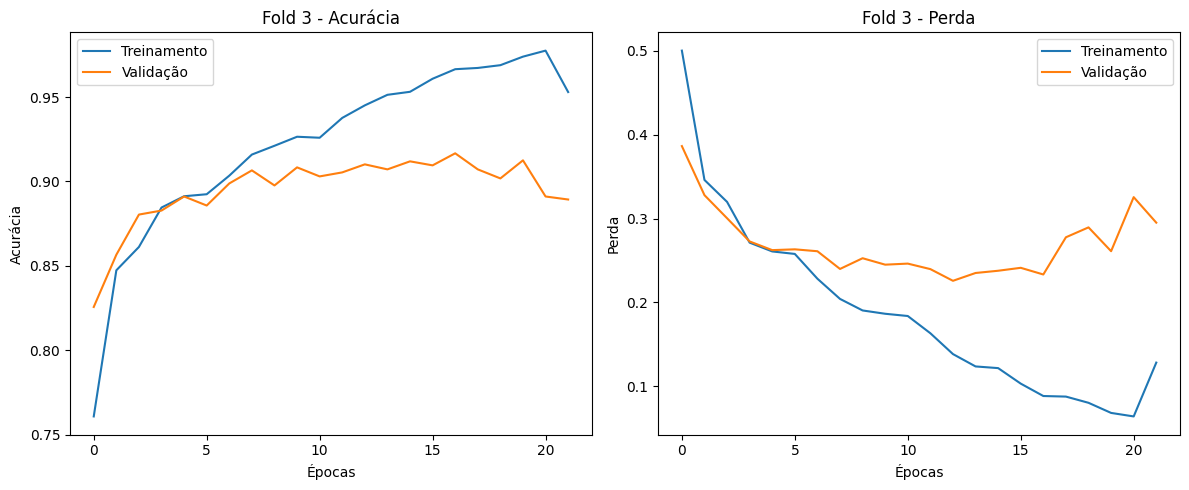

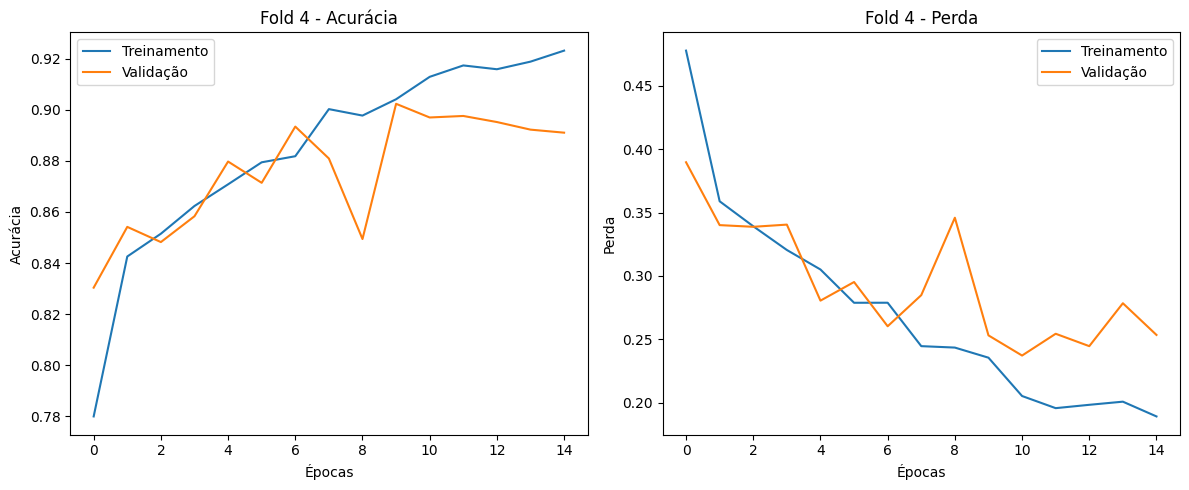

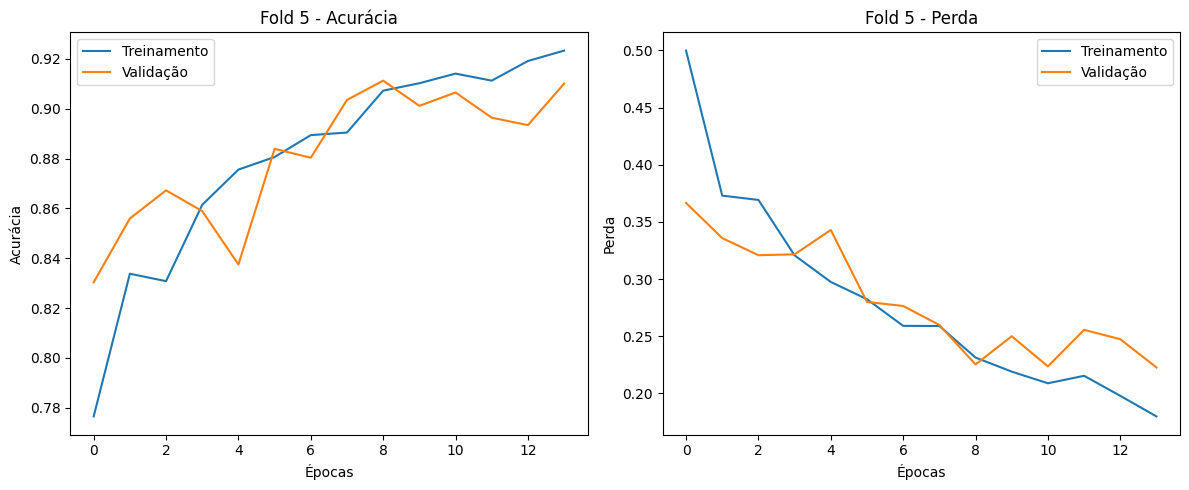

In [44]:
for fold, history in enumerate(histories):
    plt.figure(figsize=(12, 5))
    
    # plota acuracia
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Treinamento')
    plt.plot(history['val_accuracy'], label='Validação')
    plt.title(f'Fold {fold + 1} - Acurácia')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # plotar perda
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Treinamento')
    plt.plot(history['val_loss'], label='Validação')
    plt.title(f'Fold {fold + 1} - Perda')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Calculando matriz de confusão e métricas:

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


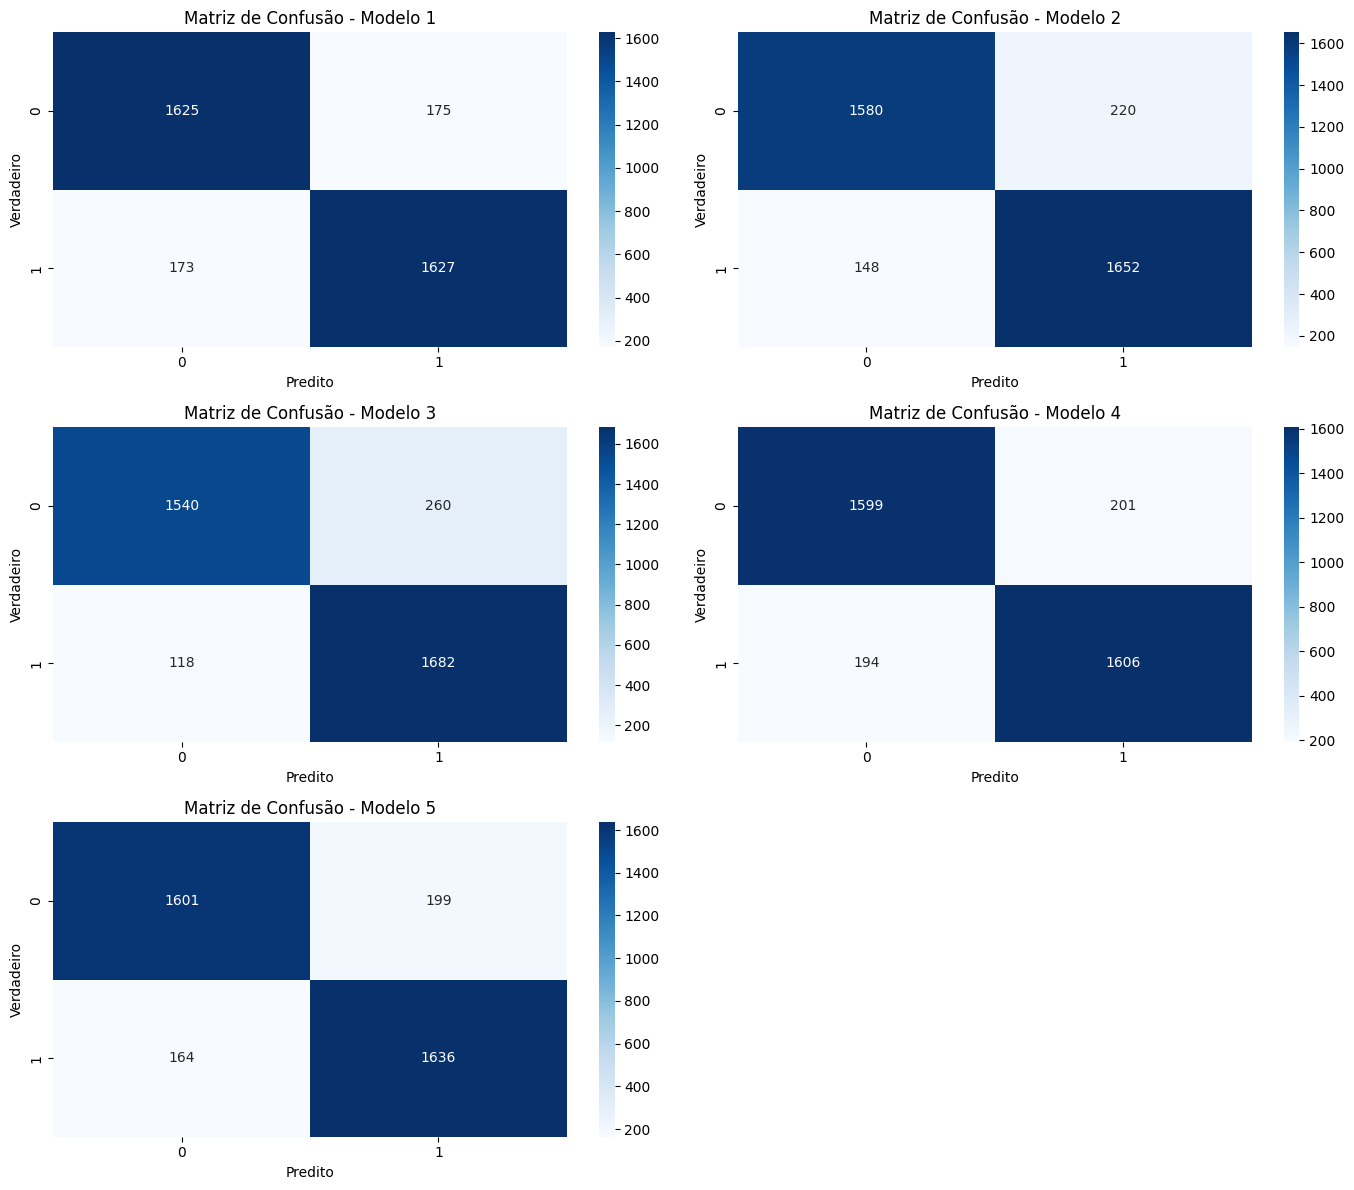

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Relatório de Classificação - Modelo 1:

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1800
           1       0.90      0.90      0.90      1800

    accuracy                           0.90      3600
   macro avg       0.90      0.90      0.90      3600
weighted avg       0.90      0.90      0.90      3600

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Relatório de Classificação - Modelo 2:

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1800
           1       0.88      0.92      0.90      1800

    accuracy                           0.90      3600
   macro avg       0.90      0.90      0.90      3600
weighted avg       0.90      0.90      0.90      3600

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Relatório de Classificação - Modelo 3:

              precision    recall  f1-score   support

           0       0.93      0.86      0.89     

In [45]:
num_models = len(models)

# cria a figura principal com subplots organizados em uma grade de 2x2
plt.figure(figsize=(14, 12))

for i, md in enumerate(models):
    y_pred = md.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes

    # cria a matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    # subplot para cada matriz de confusão
    plt.subplot(3, 2, i + 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(2), yticklabels=np.arange(2))
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title(f'Matriz de Confusão - Modelo {i + 1}')


plt.tight_layout()
plt.show()

# calcula e imprime o relatório de classificação para cada modelo
for i, md in enumerate(models):
    y_pred = md.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Converter previsões para classes
    report = classification_report(y_test, y_pred_classes, target_names=[str(i) for i in range(2)])
    print(f'Relatório de Classificação - Modelo {i + 1}:\n')
    print(report)